In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression


In [2]:
df = pd.read_csv('CSV_Files/Ledger_Metadata_2024-11-29.csv')
df = df[['Ledger_Number', 'Ledger_Date']]
df.head()

,Ledger_Number,Ledger_Date
0,91899995,2024-11-05T07:15:40.000Z
1,91900495,2024-11-05T07:48:12.000Z
2,91900995,2024-11-05T08:20:42.000Z
3,91901495,2024-11-05T08:53:11.000Z
4,91901995,2024-11-05T09:25:22.000Z


In [3]:
## Ensure that the 'Date' column is in datetime format
df['Ledger_Date'] = pd.to_datetime(df['Ledger_Date'], errors='coerce')

## Ensure that as the Ledger_Number increases so does the Date
df.sort_values(by='Ledger_Number')['Ledger_Date'].is_monotonic_increasing

# Scale ledger number
df['Ledger_Number_Scaled'] = (df['Ledger_Number'] // 500)  # Scale to increments of 1
df['Ledger_Number_Scaled'] -= df['Ledger_Number_Scaled'].min()  # Shift to start at 0
df['Ledger_Number_Scaled'].head()

0    0
1    1
2    2
3    3
4    4
Name: Ledger_Number_Scaled, dtype: int64

## Look at all the distributions for Row_Count and Ledger_Date to try and find relationship

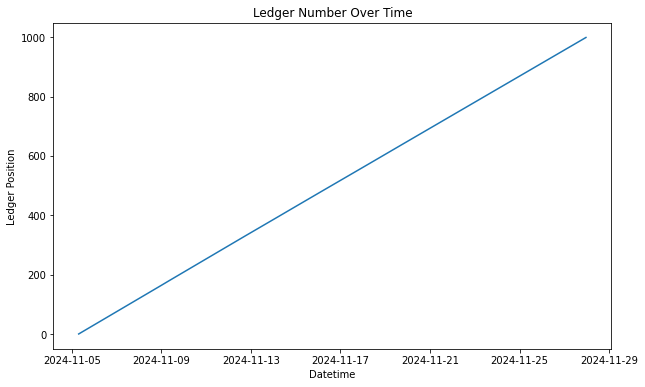

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(df['Ledger_Date'], df['Ledger_Number_Scaled'])

# Add labels, title, and grid
plt.xlabel('Datetime')
plt.ylabel('Ledger Position')
plt.title('Ledger Number Over Time')

# Display the plot
plt.show()

# Perfectly linear relationship, is the time between block creation always consistent?

In [5]:
df['Time_Between'] = df['Ledger_Date'].diff().dt.total_seconds()
df.head()

,Ledger_Number,Ledger_Date,Ledger_Number_Scaled,Time_Between
0,91899995,2024-11-05 07:15:40+00:00,0,NaN
1,91900495,2024-11-05 07:48:12+00:00,1,1952.0
2,91900995,2024-11-05 08:20:42+00:00,2,1950.0
3,91901495,2024-11-05 08:53:11+00:00,3,1949.0
4,91901995,2024-11-05 09:25:22+00:00,4,1931.0


In [6]:
print('Med:', df['Time_Between'].median())
print('Avg:', df['Time_Between'].mean())
print('Min:', df['Time_Between'].min())
print('Max:', df['Time_Between'].max())

Med: 1961.0000000000002
Avg: 1964.2427281845542
Min: 1861.0000000000002
Max: 3941.0000000000005


## Looks to be generally consistent, but there is some variation, plotting for a better view

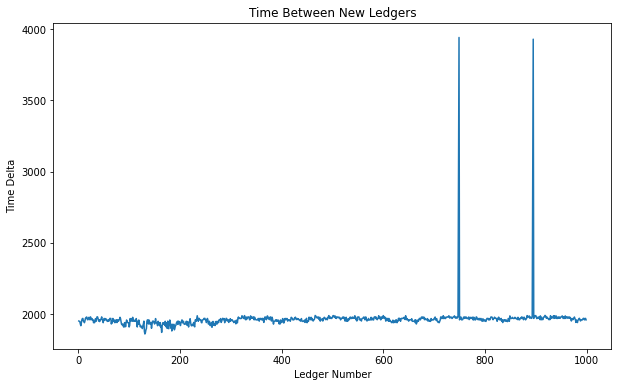

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(df['Ledger_Number_Scaled'], df['Time_Between'])

plt.xlabel('Ledger Number')
plt.ylabel('Time Delta')
plt.title('Time Between New Ledgers')

plt.show()

## Graph shows 2 possibilities to explore, what is going on with the two time spikes, and it looks like the variation in time between ledgers seems to be decreasing over time

### Plot graph without the (assumed to be) 2 outliers to get a better view of the variance over time

In [8]:
df['z_score'] = zscore(df['Time_Between'], nan_policy='omit')
df.sort_values(by='z_score', ascending=False).head(10)

,Ledger_Number,Ledger_Date,Ledger_Number_Scaled,Time_Between,z_score
748,92274495,2024-11-22 06:27:41+00:00,749,3941.0,21.895084
893,92347495,2024-11-25 14:16:11+00:00,895,3929.0,21.762169
466,92132995,2024-11-15 19:48:02+00:00,466,1991.0,0.296371
916,92358995,2024-11-26 02:53:51+00:00,918,1991.0,0.296371
898,92349995,2024-11-25 17:01:30+00:00,900,1990.0,0.285294
600,92199995,2024-11-18 21:09:51+00:00,600,1990.0,0.285294
882,92341495,2024-11-25 07:41:00+00:00,883,1990.0,0.285294
917,92359495,2024-11-26 03:27:01+00:00,919,1990.0,0.285294
502,92150995,2024-11-16 15:31:20+00:00,502,1990.0,0.285294
327,92063495,2024-11-12 16:00:51+00:00,327,1990.0,0.285294


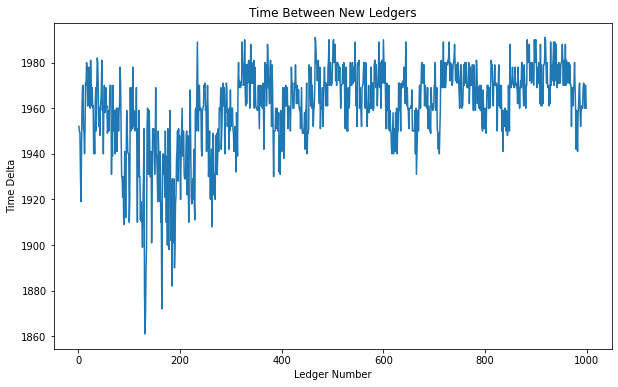

In [9]:
# 2 outliers confirmed, remove them, replot
df_cleaned = df.copy()
df_cleaned = df_cleaned[df_cleaned['z_score'].abs() <= 20]

plt.figure(figsize=(10, 6))
plt.plot(df_cleaned['Ledger_Number_Scaled'], df_cleaned['Time_Between'])

plt.xlabel('Ledger Number')
plt.ylabel('Time Delta')
plt.title('Time Between New Ledgers')

plt.show()


## Decreasing variance still looks like a solid possibility
## Performing variance over time EDA

### Plot variance

No handles with labels found to put in legend.


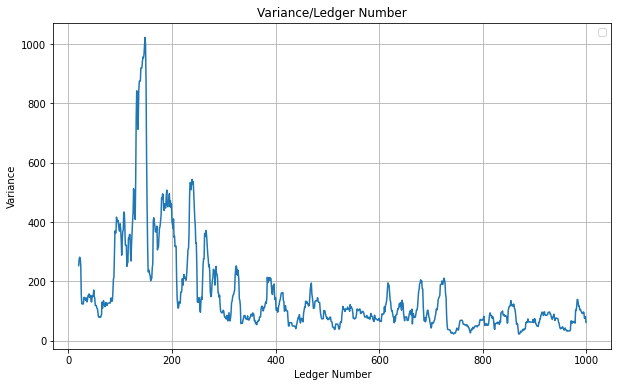

In [14]:
df_cleaned['Variance'] = df_cleaned['Time_Between'].rolling(window=20).var()

plt.figure(figsize=(10, 6))
plt.plot(df_cleaned['Ledger_Number_Scaled'], df_cleaned['Variance'])

plt.title('Variance/Ledger Number')
plt.xlabel('Ledger Number')
plt.ylabel('Variance')
plt.legend()
plt.grid(True)

plt.show()

## Appears to approach zero

### Confirm findings with Linear Regression

No handles with labels found to put in legend.


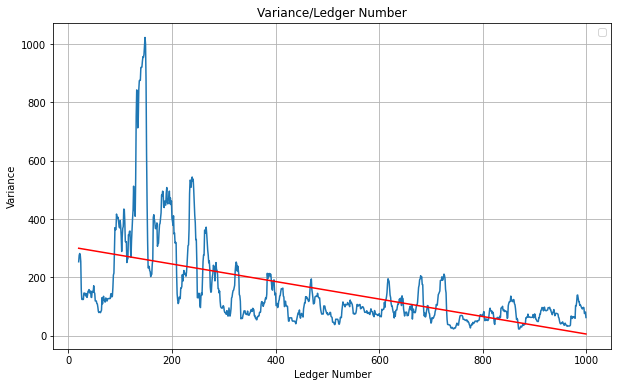

Slope: -0.30018
R^2: 0.30525


In [15]:
df_clean = df_cleaned[['Ledger_Number_Scaled', 'Variance']].dropna()

X = df_clean['Ledger_Number_Scaled'].to_numpy().reshape(-1, 1)
y = df_clean['Variance'].to_numpy()

model = LinearRegression()
model.fit(X, y)

# Get regression line predictions
predictions = model.predict(X)


plt.figure(figsize=(10, 6))
plt.plot(df_clean['Ledger_Number_Scaled'], df_clean['Variance'])
plt.plot(df_clean['Ledger_Number_Scaled'], predictions, color='red')

plt.title('Variance/Ledger Number')
plt.xlabel('Ledger Number')
plt.ylabel('Variance')
plt.legend()
plt.grid(True)

plt.show()
print('Slope:', round(model.coef_[0], 5))
print('R^2:', round(model.score(X, y), 5))


## Repeat test with variance outliers removed

In [16]:
df_var_outliers = df_cleaned.copy()
df_var_outliers['z_score'] = zscore(df_var_outliers['Variance'], nan_policy='omit')
print(df_var_outliers.sort_values(by='z_score', ascending=False).head(30))

     Ledger_Number               Ledger_Date  Ledger_Number_Scaled  \
148       91973995 2024-11-08 15:21:01+00:00                   148   
149       91974495 2024-11-08 15:53:21+00:00                   149   
147       91973495 2024-11-08 14:48:30+00:00                   147   
146       91972995 2024-11-08 14:16:01+00:00                   146   
144       91971995 2024-11-08 13:11:22+00:00                   144   
145       91972495 2024-11-08 13:43:30+00:00                   145   
143       91971495 2024-11-08 12:39:41+00:00                   143   
142       91970995 2024-11-08 12:07:20+00:00                   142   
140       91969995 2024-11-08 11:03:00+00:00                   140   
141       91970495 2024-11-08 11:35:10+00:00                   141   
150       91974995 2024-11-08 16:25:32+00:00                   150   
138       91968995 2024-11-08 09:57:51+00:00                   138   
139       91969495 2024-11-08 10:30:30+00:00                   139   
137       91968495 2

No handles with labels found to put in legend.


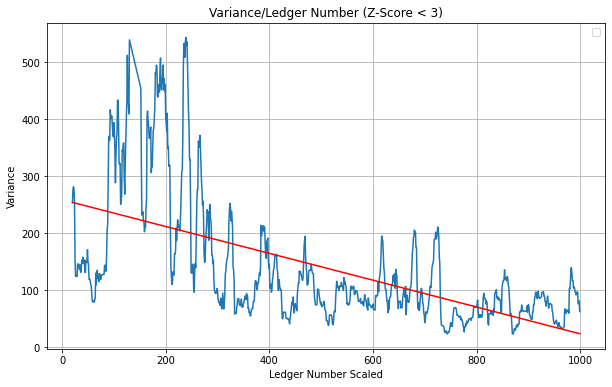

Slope: -0.23572
R^2: 0.36198


In [17]:
df_var_outliers = df_var_outliers[df_var_outliers['z_score'].abs() <= 3]

X = df_var_outliers['Ledger_Number_Scaled'].to_numpy().reshape(-1, 1)
y = df_var_outliers['Variance'].to_numpy()

model = LinearRegression()
model.fit(X, y)

# Get regression line predictions
predictions = model.predict(X)


plt.figure(figsize=(10, 6))
plt.plot(df_var_outliers['Ledger_Number_Scaled'], df_var_outliers['Variance'])
plt.plot(df_var_outliers['Ledger_Number_Scaled'], predictions, color='red')

plt.title('Variance/Ledger Number (Z-Score < 3)')
plt.xlabel('Ledger Number Scaled')
plt.ylabel('Variance')
plt.legend()
plt.grid(True)

plt.show()
print('Slope:', round(model.coef_[0], 5))
print('R^2:', round(model.score(X, y), 5))

### Regression model provides a solid case for a downward trend in variance